In [1]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# path = "data\HDFS_2K\HDFS_2k.log_structured.csv"
# df = pd.read_csv(path)
# df_filtered = df.groupby('EventId')["EventTemplate"].count()
# df_filtered

#dist of logs
event_counts = {
    'E1': 80,
    'E10': 311,
    'E11': 292,
    'E12': 2,
    'E13': 292,
    'E14': 20,
    'E2': 1,
    'E3': 80,
    'E4': 5,
    'E5': 1,
    'E6': 314,
    'E7': 115,
    'E8': 224,
    'E9': 263
}


max_count = max(event_counts.values())

# normalise weights
normalized_weights = {event: count / max_count for event, count in event_counts.items()}

print(normalized_weights)


{'E1': 0.25477707006369427, 'E10': 0.9904458598726115, 'E11': 0.9299363057324841, 'E12': 0.006369426751592357, 'E13': 0.9299363057324841, 'E14': 0.06369426751592357, 'E2': 0.0031847133757961785, 'E3': 0.25477707006369427, 'E4': 0.01592356687898089, 'E5': 0.0031847133757961785, 'E6': 1.0, 'E7': 0.3662420382165605, 'E8': 0.7133757961783439, 'E9': 0.8375796178343949}


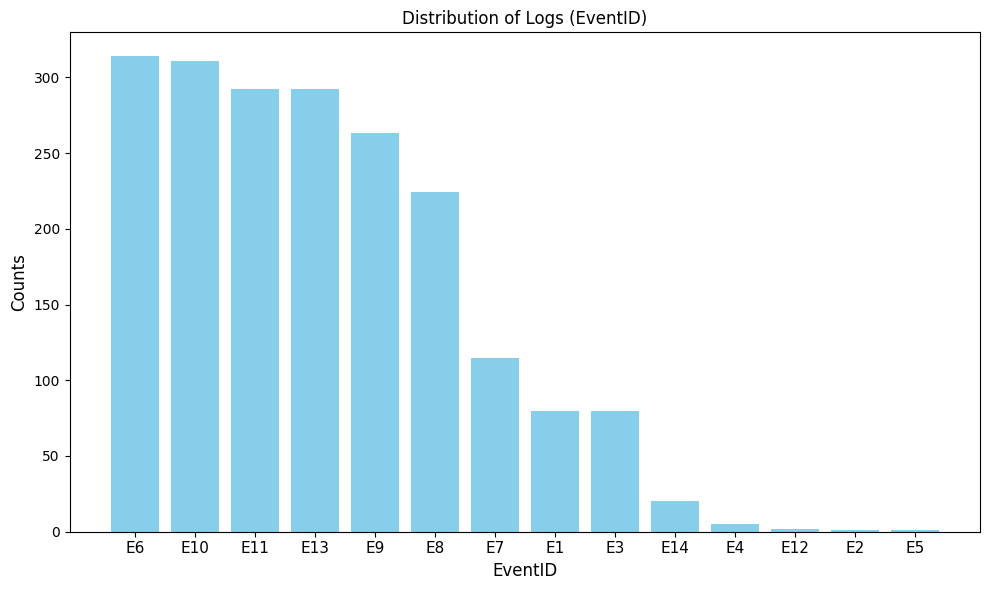

In [3]:
sorted_event_counts = dict(sorted(event_counts.items(), key=lambda x: x[1], reverse=True))
events = list(sorted_event_counts.keys())
counts = list(sorted_event_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(events, counts, color='skyblue')
plt.xlabel('EventID', fontsize = 12)
plt.ylabel('Counts', fontsize = 12)
plt.yticks(fontsize = 10)
plt.title('Distribution of Logs (EventID)')
plt.xticks(fontsize = 11)
plt.tight_layout()
plt.show()

In [4]:
def calculate_ga(df, weights=None):
    # group by GT
    grouped = df.groupby('LogTemplate')
    correctly_grouped = 0
    total_weight = 0
    
   
    for log_template, group in grouped:
        # use weights if given, else default
        group_weight = weights.get(log_template, 1) if weights else 1
        if group['LLMOutput'].nunique() == 1:
            correctly_grouped += group_weight * len(group)
        
        total_weight += group_weight * len(group)
    
    if total_weight == 0:
        ga = 0
    else: ga = correctly_grouped / total_weight
    return ga

In [5]:
#Note: Code closely inspired by logpai Loghub
# https://github.com/logpai/loghub-2.0
def calculate_pa(df, weights=None):
    correctly_parsed = 0
    total_weight = 0
    
    for idx, row in df.iterrows():
        ground_truth_tokens = row['LogTemplate'].split()
        parsed_tokens = row['LLMOutput'].split()
        
        if len(ground_truth_tokens) != len(parsed_tokens):
            continue
        
        correct = True
        for gt_token, parsed_token in zip(ground_truth_tokens, parsed_tokens):
            if (gt_token == "<*>" and parsed_token != "<*>") or (gt_token != "<*>" and gt_token != parsed_token):
                correct = False
                break
        
        event_id = row['EventId']
        weight = weights.get(event_id, 1) if weights else 1
        
        if correct:
            correctly_parsed += weight
        
        total_weight += weight
        
    if total_weight == 0:
        pa = 0
    else: pa = correctly_parsed / total_weight
    return pa

In [6]:
#Note: Code closely inspired by logpai Loghub
# https://github.com/logpai/loghub-2.0
def calculate_template_accuracies(df):
    total_messages = 0
    correct_parsing_templates = 0
    null_logids = df[~df['LogTemplate'].isnull()].index
    df = df.loc[null_logids]
    series_groundtruth = df['LogTemplate']
    series_parsedlog = df['LLMOutput']
    series_groundtruth_valuecounts = series_groundtruth.value_counts()

    df_combined = pd.concat([series_groundtruth, series_parsedlog], axis=1, keys=['groundtruth', 'parsedlog'])
    grouped_df = df_combined.groupby('parsedlog')
    
    for identified_template, group in grouped_df:
        total_messages += 1
        corr_oracle_templates = set(list(group['groundtruth']))
        if corr_oracle_templates == {identified_template}:
            correct_parsing_templates += 1

    PTA = correct_parsing_templates / total_messages
    RTA = correct_parsing_templates / len(series_groundtruth_valuecounts)
    
    return PTA, RTA


def calculate_f1ta(pta, rta):
    if pta + rta == 0:
        return 0.0
    return 2 * (pta * rta) / (pta + rta)

In [7]:
def compute(df, weights=None):
    # valculates metrics given df
    ga = calculate_ga(df, weights)
    pa = calculate_pa(df, weights)
    pta, rta = calculate_template_accuracies(df)
    f1ta = calculate_f1ta(pta, rta)

    return {'Grouping Accuracy (GA)': ga,
            'Parsing Accuracy (PA)': pa,
            'Precision Template Accuracy (PTA)': pta,
            'Recall Template Accuracy (RTA)': rta,
            'F1-score-TA (F1TA)': f1ta}

In [8]:
def load_csvs_from_folder(folder_path):
    #goes through csvs in a  folder (level 0 to 4 log)
    csv_files = sorted(glob.glob(os.path.join(folder_path, '*.csv')))

    dataframes = {}

    for i, file in enumerate(csv_files):
        df = pd.read_csv(file)
        dataframes[f'df{i}'] = df
    
    return dataframes

In [9]:
def plot_metrics(dataframes, num):
    metrics = ['Grouping Accuracy (GA)', 'Parsing Accuracy (PA)', 'F1-score-TA (F1TA)']
    metrics1 = ['GA', 'PA', 'F1TA']
    #metrics = ['Parsing Accuracy (PA)', 'F1-score-TA (F1TA)']
    num_metrics = len(metrics)
    num_dataframes = len(dataframes)
    
    # computing scores for each df
    values = {metric: [compute(dataframes[df], normalized_weights)[metric] for df in dataframes] for metric in metrics}
    
    # bar params
    bar_width = 0.65 / num_dataframes
    index = np.arange(num_metrics)
    

    fig, ax = plt.subplots(figsize=(10, 6))
    
    # plot bars for each df
    for i, (df_name, df_values) in enumerate(dataframes.items()):
        metric_values = [values[metric][i] for metric in metrics]
        ax.bar(index + i * bar_width, metric_values, bar_width, label=df_name)
    

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title(f'Comparison of Metrics Across Augmented Datasets {num}-shot')
    ax.set_xticks(index + bar_width * (num_dataframes - 1) / 2)
    ax.set_xticklabels(metrics1, fontsize = 11)
    ax.legend()
    ax.legend(loc='upper right', bbox_to_anchor=(0.8, +1), shadow=True, ncol=2)
    plt.show()

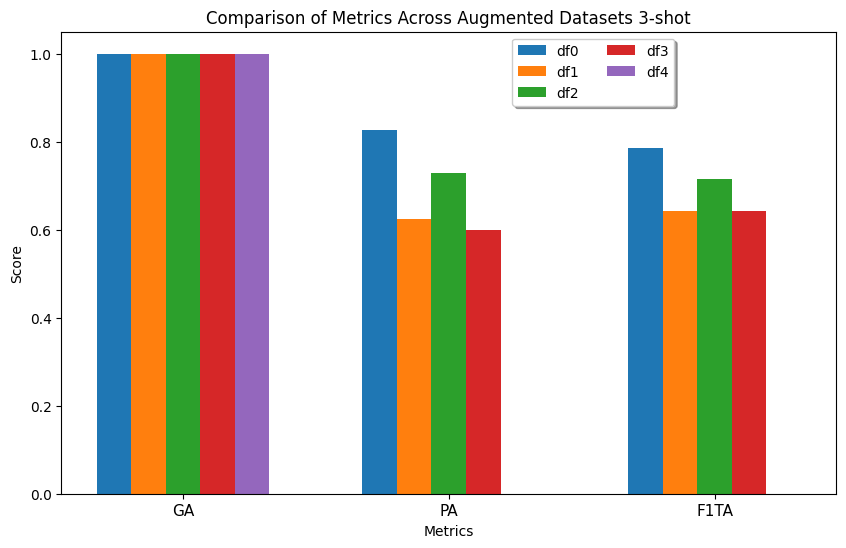

In [10]:
dataframes3 = load_csvs_from_folder("data\parsed\\FINAL\\3ParsedFull")
plot_metrics(dataframes3, 3)

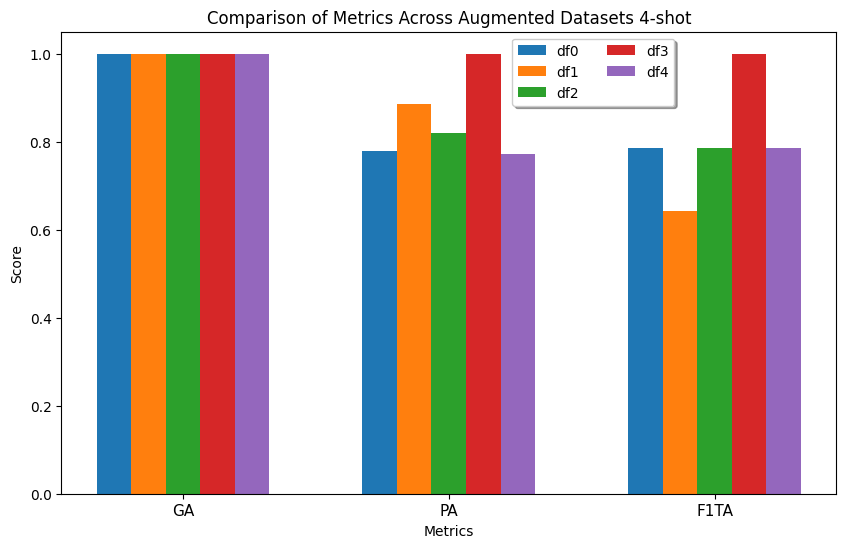

In [11]:
dataframes4 = load_csvs_from_folder("data\parsed\\FINAL\\4ParsedFull")
plot_metrics(dataframes4, 4)


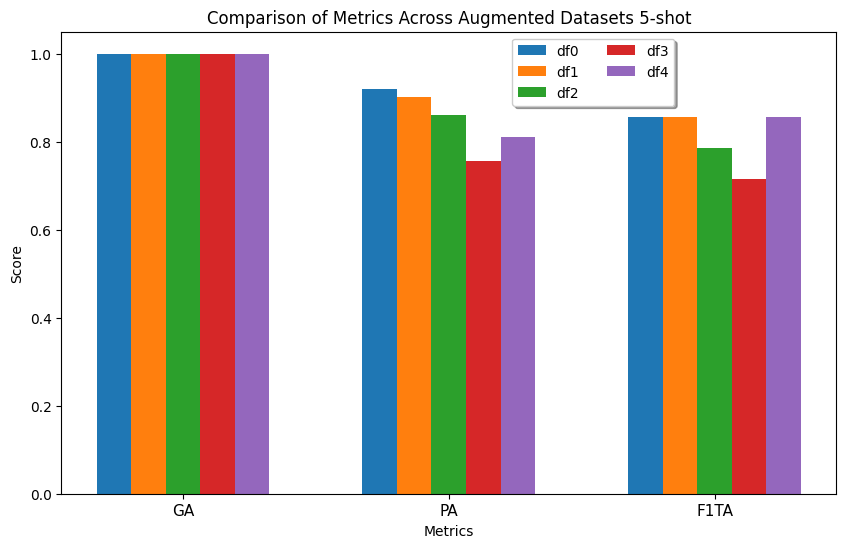

In [12]:
dataframes5 = load_csvs_from_folder("data\parsed\\FINAL\\5ParsedFull")
plot_metrics(dataframes5, 5)

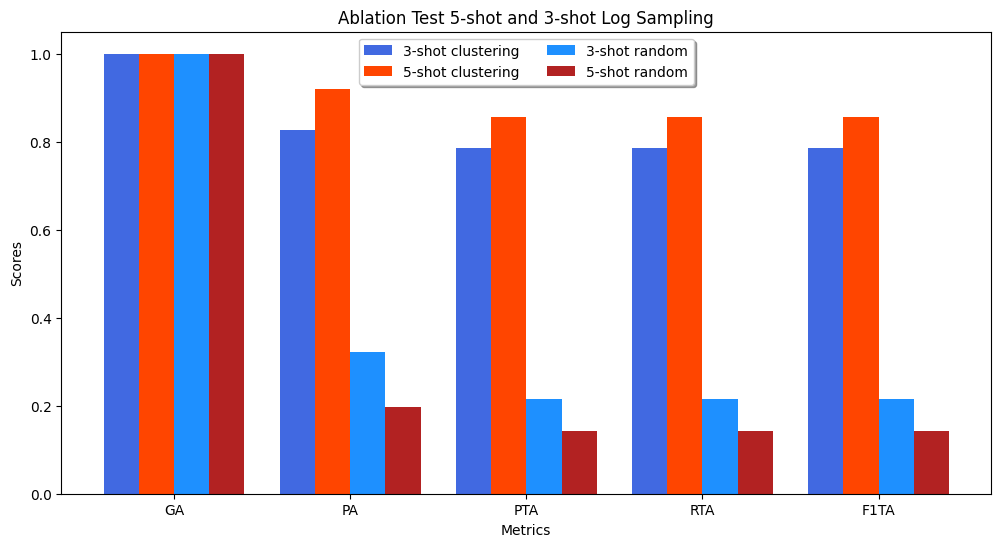

In [13]:
def plot_metrics_abl(dataframes):
    metrics = ['Grouping Accuracy (GA)', 'Parsing Accuracy (PA)', 
               'Precision Template Accuracy (PTA)', 
               'Recall Template Accuracy (RTA)', 'F1-score-TA (F1TA)']
    metrics1 = ['GA', 'PA', 'PTA', 'RTA', 'F1TA']
    #metrics = ['Parsing Accuracy (PA)', 'F1-score-TA (F1TA)']
    num_metrics = len(metrics)
    num_dataframes = len(dataframes)
    
    # val for each df
    values = {metric: [compute(dataframes[df], normalized_weights)[metric] for df in dataframes] for metric in metrics}
    
    # bar params
    bar_width = 0.8 / num_dataframes
    index = np.arange(num_metrics)

    fig, ax = plt.subplots(figsize=(12, 6))
    
    # custom labels and colours
    bar_labels = ["3-shot clustering", "5-shot clustering", "3-shot random", "5-shot random"]
    colors = ['royalblue', 'orangered', 'dodgerblue', 'firebrick']

    for i, (df_name, df_values) in enumerate(dataframes.items()):
        metric_values = [values[metric][i] for metric in metrics]
        ax.bar(index + i * bar_width, metric_values, bar_width, label=bar_labels[i], color=colors[i])
    

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Ablation Test 5-shot and 3-shot Log Sampling')
    ax.set_xticks(index + bar_width * (num_dataframes - 1) / 2)
    ax.set_xticklabels(metrics1)
    ax.legend()

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, +1), shadow=True, ncol=2)
    
    plt.show()

abl= load_csvs_from_folder("data\parsed\\abltest")
plot_metrics_abl(abl)

In [14]:
def metrics_to_dataframe(dataframes):
    metrics = ['Grouping Accuracy (GA)', 'Parsing Accuracy (PA)', 
               'Precision Template Accuracy (PTA)', 
               'Recall Template Accuracy (RTA)', 'F1-score-TA (F1TA)']
    metrics1 = ['GA', 'PA', 'PTA', 'RTA', 'F1TA']
    num_metrics = len(metrics)
    num_dataframes = len(dataframes)
    
    # computing scores for each df
    values = {metric: [round(compute(dataframes[df], normalized_weights)[metric], 3) for df in dataframes] for metric in metrics}
    
    # Idict for metrics per df
    data = {'Metric': metrics1}
    
    # add vals to dict
    for i, (df_name, _) in enumerate(dataframes.items()):
        data[df_name] = [values[metric][i] for metric in metrics]

    result_df = pd.DataFrame(data)
    pd.options.display.float_format = '{:.3f}'.format
    return result_df.T

In [15]:
res3 =load_csvs_from_folder("data\parsed\\FINAL\\3ParsedFull")
metrics_to_dataframe(res3)

,0,1,2,3,4
Metric,GA,PA,PTA,RTA,F1TA
df0,1.000,0.826,0.786,0.786,0.786
df1,1.000,0.624,0.643,0.643,0.643
df2,1.000,0.730,0.714,0.714,0.714
df3,1.000,0.600,0.643,0.643,0.643
df4,1.000,0.000,0.000,0.000,0.000


In [16]:
res4 =load_csvs_from_folder("data\parsed\\FINAL\\4ParsedFull")
metrics_to_dataframe(res4)

,0,1,2,3,4
Metric,GA,PA,PTA,RTA,F1TA
df0,1.000,0.780,0.786,0.786,0.786
df1,1.000,0.886,0.643,0.643,0.643
df2,1.000,0.820,0.786,0.786,0.786
df3,1.000,1.000,1.000,1.000,1.000
df4,1.000,0.771,0.786,0.786,0.786


In [17]:
res5 =load_csvs_from_folder("data\parsed\\FINAL\\5ParsedFull")
metrics_to_dataframe(res5)

,0,1,2,3,4
Metric,GA,PA,PTA,RTA,F1TA
df0,1.000,0.920,0.857,0.857,0.857
df1,1.000,0.903,0.857,0.857,0.857
df2,1.000,0.862,0.786,0.786,0.786
df3,1.000,0.755,0.714,0.714,0.714
df4,1.000,0.811,0.857,0.857,0.857


In [18]:
data = {
    "Metric": ["GA", "PA", "PTA", "RTA", "F1TA"],
    "df0 n=3": [1.000, 0.826, 0.786, 0.786, 0.786],
    "df0 n=4": [1.000, 0.780, 0.786, 0.786, 0.786],
    "df0 n=5": [1.000, 0.920, 0.857, 0.857, 0.857]
}

df = pd.DataFrame(data)
df

,Metric,df0 n=3,df0 n=4,df0 n=5
0,GA,1.000,1.000,1.000
1,PA,0.826,0.780,0.920
2,PTA,0.786,0.786,0.857
3,RTA,0.786,0.786,0.857
4,F1TA,0.786,0.786,0.857


In [19]:

def aggregate_metrics_abl(dataframes):
    metrics = ['Grouping Accuracy (GA)', 'Parsing Accuracy (PA)', 
               'Precision Template Accuracy (PTA)', 
               'Recall Template Accuracy (RTA)', 'F1-score-TA (F1TA)']
    metrics1 = ['GA', 'PA', 'PTA', 'RTA', 'F1TA']
    num_metrics = len(metrics)
    num_dataframes = len(dataframes)
    
    # computing scores for each df
    values = {metric: [compute(dataframes[df], normalized_weights)[metric] for df in dataframes] for metric in metrics}
    
    # custom names
    custom_columns = ["3-shot clustering", "5-shot clustering", "3-shot random", "5-shot random"]
    
    #df scores
    df_scores = pd.DataFrame(index=metrics1, columns=custom_columns)
    
    # add scores to df
    for i, metric in enumerate(metrics):
        df_scores.iloc[i, :] = [values[metric][j] for j in range(num_dataframes)]
    
    return df_scores

abl= load_csvs_from_folder("data\parsed\\abltest")
df_scores = aggregate_metrics_abl(abl)
print(df_scores)


     3-shot clustering 5-shot clustering 3-shot random 5-shot random
GA               1.000             1.000         1.000         1.000
PA               0.826             0.920         0.323         0.198
PTA              0.786             0.857         0.214         0.143
RTA              0.786             0.857         0.214         0.143
F1TA             0.786             0.857         0.214         0.143


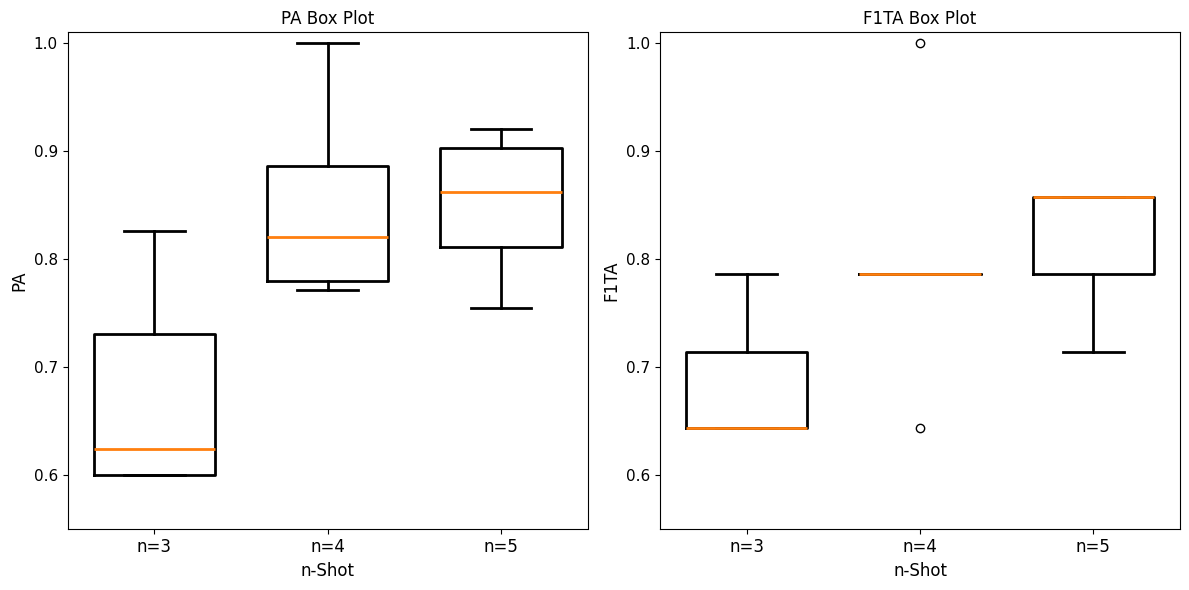

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# boxplot data (from previous cells)
data = {
    'Datasets': ['df0', 'df1', 'df2', 'df3', 'df4'],
    'GA_n3': [1, 1, 1, 1, 1],
    'PA_n3': [0.826, 0.624, 0.730, 0.600, 0.000],
    'F1TA_n3': [0.786, 0.643, 0.714, 0.643, 0.000],
    'GA_n4': [1, 1, 1, 1, 1],
    'PA_n4': [0.780, 0.886, 0.820, 1, 0.771],
    'F1TA_n4': [0.786, 0.643, 0.786, 1, 0.786],
    'GA_n5': [1, 1, 1, 1, 1],
    'PA_n5': [0.920, 0.903, 0.862, 0.755, 0.811],
    'F1TA_n5': [0.857, 0.857, 0.786, 0.714, 0.857],
}


df = pd.DataFrame(data)
pa_data = [df['PA_n3'], df['PA_n4'], df['PA_n5']]
f1ta_data = [df['F1TA_n3'], df['F1TA_n4'], df['F1TA_n5']]


plt.figure(figsize=(12, 6))

# PA
plt.subplot(1, 2, 1)
bplot1 = plt.boxplot(pa_data, labels=['n=3', 'n=4', 'n=5'], patch_artist=False, widths=0.7)
plt.title('PA Box Plot')
plt.xlabel('n-Shot', fontsize=12)
plt.ylabel('PA', fontsize=12)
plt.ylim(0.55, 1.01)
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)

for component in bplot1.keys():
    plt.setp(bplot1[component], linewidth=2)

# F1TA
plt.subplot(1, 2, 2)
bplot2 = plt.boxplot(f1ta_data, labels=['n=3', 'n=4', 'n=5'], patch_artist=False, widths=0.7)
plt.title('F1TA Box Plot')
plt.xlabel('n-Shot', fontsize=12)
plt.ylabel('F1TA', fontsize=12)
plt.ylim(0.55, 1.01)
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)

for component in bplot2.keys():
    plt.setp(bplot2[component], linewidth=2)

plt.tight_layout()
plt.show()
